In [1]:
from fastai.vision import *
import pickle as pkl
import builtins

In [2]:
output_path   = Path('output')

train_path = output_path/'train_patchlets'
test_path  = output_path/'test_patchlets'

### Create custom ItemList and LabelList classes to define data loading and display

In [3]:
class SegmentationPklLabelList(SegmentationLabelList):
    def open(self, fn):
        x = pkl.load(builtins.open(str(fn),'rb'))[None,...].astype(np.float32)
        return ImageSegment(tensor(x))

class SegmentationPklList(SegmentationItemList):
    _label_cls,_square_show_res = SegmentationPklLabelList,False
    
    def open(self, fn):
        x = pkl.load(builtins.open(str(fn),'rb'))
        x = x.transpose([0,3,1,2]).reshape([-1,64,64]).astype(np.float32)
        return Image(tensor(x))
    
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()): Image(torch.clamp(x.data[0:3,:,:]*3.5,0,1)).show(ax=ax, y=y, alpha=0.4,**kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

### Define validation function
##### Validation patchlets all come from a separate patch 

In [4]:
def valid_patch(fn, i=6):
    return f'patch_{i}' in str(fn)

def get_mask(fn):
    return str(fn).replace('feat','targ')

def exclude_masks(fn):
    return not('targ' in str(fn.name))

In [5]:
bs = 32
classes=['No Data',        
         'Cotton',         
         'Dates',          
         'Grass',          
         'Lucern',         
         'Maize',          
         'Pecan',          
         'Vacant',         
         'Vineyard',       
         'Vineyard & Pecan']

src = (SegmentationPklList.from_folder(train_path, extensions=['.pkl'], 
                                       recurse=True, convert_mode='L')
       
       .filter_by_func(exclude_masks)
       .split_by_valid_func(valid_patch)
       .label_from_func(get_mask, classes=classes)
)

test_set = (SegmentationPklList.from_folder(test_path, extensions=['.pkl'], 
                                       recurse=True, convert_mode='L')
       .filter_by_func(exclude_masks)
)

In [6]:
stats_data = src.databunch(bs=128)
x,y = stats_data.one_batch()

In [7]:
means = x.mean(dim=[0,2,3])
stds = x.std(dim=[0,2,3])

### Define focal loss function

In [8]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, crit, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.crit = crit
    
    def forward(self, inputs, targets, reduction):
        loss = self.crit(inputs, targets)
        pt = torch.exp(-loss)
        F_loss = self.alpha * (1-pt)**self.gamma * loss

        if reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

### Define data augmentation and get databunch

In [9]:
tfms = get_transforms(    
    do_flip = True,
    flip_vert = True,
    max_rotate = 20,
    max_zoom = 1.2,
    max_lighting = 0.,
    max_warp = 0.4,
    p_affine = 0.9,
    p_lighting = 0.,
    xtra_tfms = [cutout(n_holes=(5,30), length=(3, 10), p=0.9, use_on_y=False)]
)

tfms = [tfms[0][1:],[]]# gets rid of resize transformations - they don't work the target mask

data = (src
        .transform(tfms, 
                   tfm_y=True)
        .add_test(test_set,tfms=None)
        .databunch(bs=bs, num_workers = 0)
        .normalize(stats=(means,stds)))

### View a batch to check data augmentation (targets masks are overlaid with transparency)

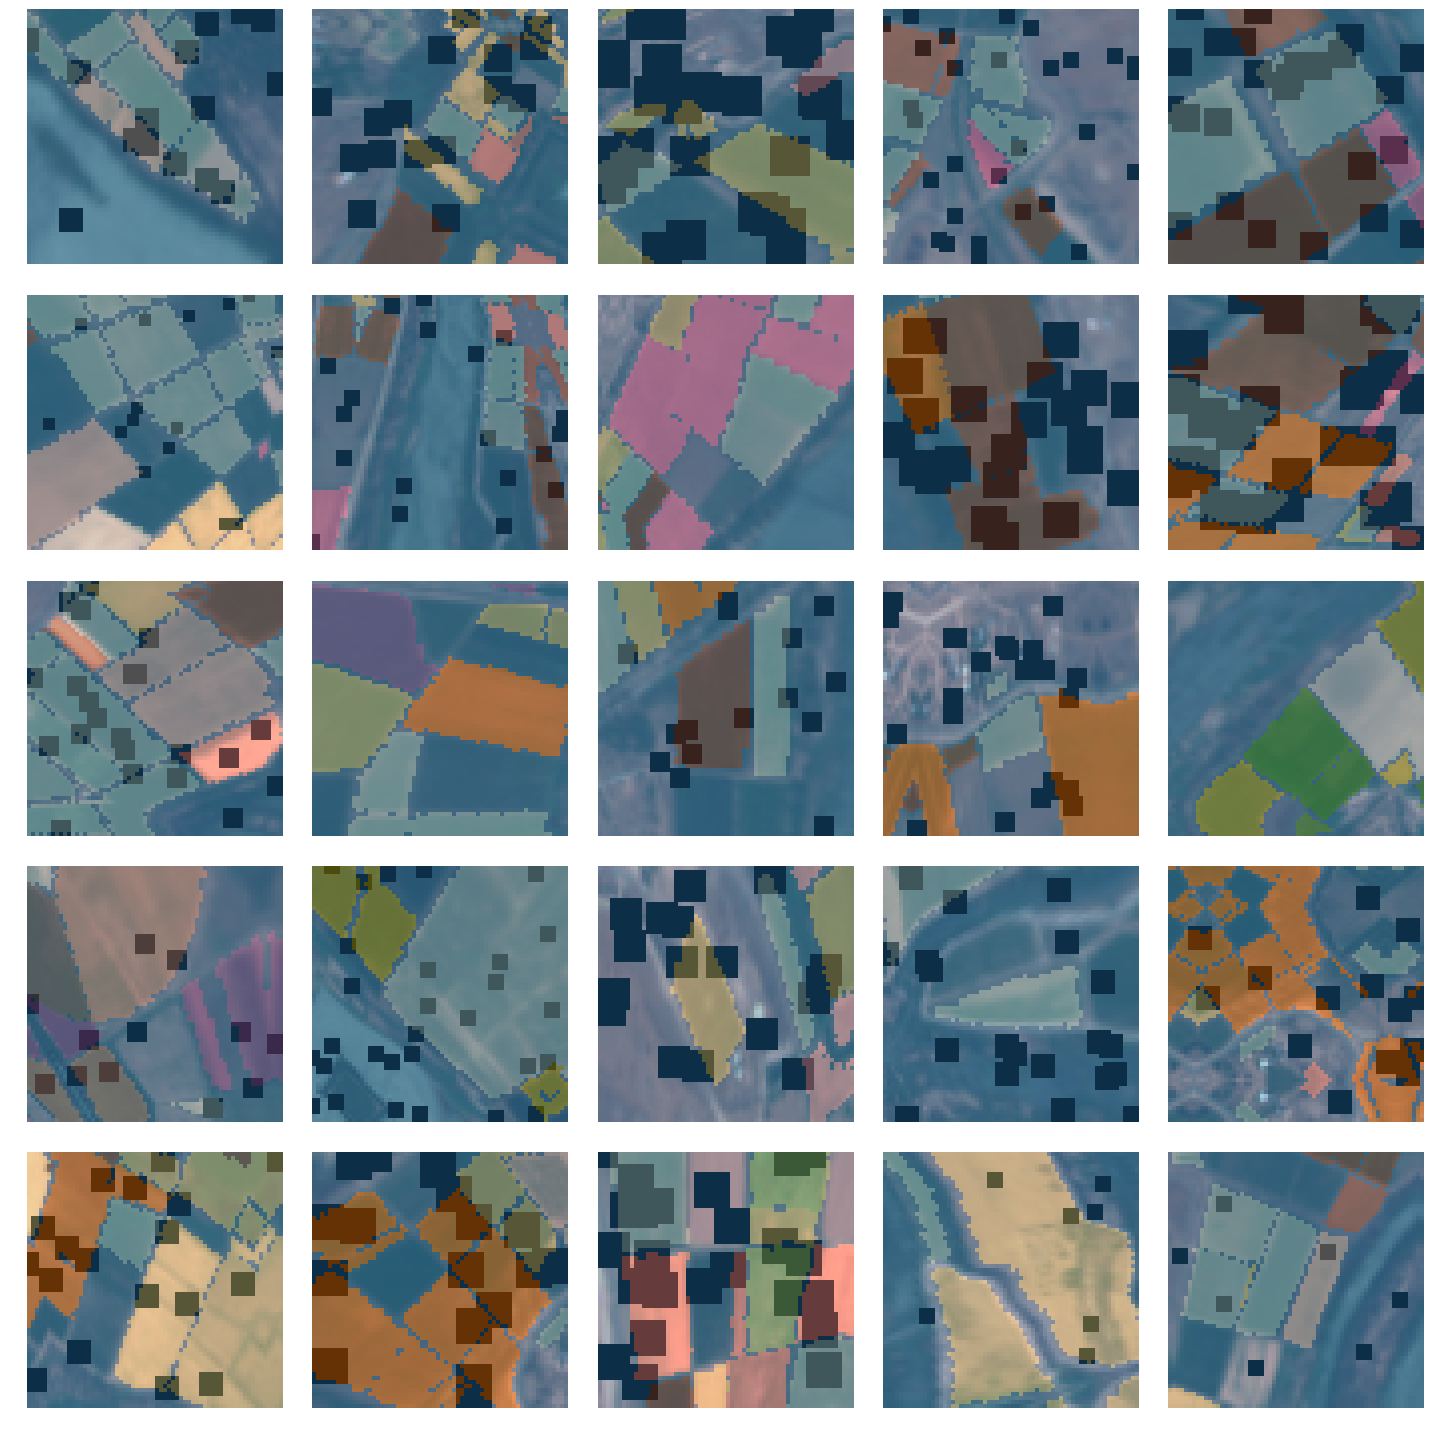

In [10]:
data.show_batch()

### Define a custom ResNet that takes the appropriate number of input channels

In [11]:
in_ch = 8*6 # 8 timepoints x 6 channels (R + G + B + NIR + NDVI + NORM)

In [12]:
def myresnet_func(*args):
    myresnet = models.resnet50(pretrained=True)
    myresnet.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    return myresnet

### Define some metrics

In [13]:
def pixel_acc(inputs, targs):
    inputs = inputs.argmax(dim=1)[:,None,...]
    return (targs[targs!=0]==inputs[targs!=0]).float().mean()

def pixel_acc_per_class(inputs, targs, class_id=None):
    inputs = inputs.argmax(dim=1)[:,None,...]
    inputs = inputs[targs==class_id]
    targs = targs[targs==class_id]
    pixels = len(targs)
    if pixels > 0:
        score = ((targs[targs!=0]==inputs[targs!=0])).float().mean()
    else:
        score = -1
    return pixels, score

### Modify the fastai mixup callback to work with image segmentation

In [14]:
class myMixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, stack_x:bool=False, stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_x,self.stack_y = alpha,stack_x,stack_y
    
    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = myMixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies mixup to `last_input` and `last_target` if `train`."
        if not train: return
        lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
        lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
        lambd = last_input.new(lambd)

        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        if self.stack_x:
            new_input = [last_input, last_input[shuffle], lambd]
        else: 
            out_shape = [lambd.size(0)] + [1 for _ in range(len(x1.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + x1 * (1-lambd).view(out_shape))
        if self.stack_y:
            
            new_lambd = torch.distributions.utils.broadcast_all(lambd[:,None,None,None], last_target)[0]
            
            #new_target = torch.cat([last_target[:,None].float(), y1[:,None].float(), new_lambd[:,None].float()], 1)
            new_target = torch.stack([last_target.float(), y1.float(), new_lambd.float()], 1)
        else:
            if len(last_target.shape) == 2:
                lambd = lambd.unsqueeze(1).float()
            new_target = last_target.float() * lambd + y1.float() * (1-lambd)
            
        return {'last_input': new_input, 'last_target': new_target}  
    
    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()
        

class myMixUpLoss(Module):
    "Adapt the loss function `crit` to go with mixup."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        
    def forward(self, output, target):
        if len(target.size()) >= 5:
            loss1, loss2 = self.crit(output,target[:,0].long()), self.crit(output,target[:,1].long())
            lambd = target[:,2].contiguous().view(-1)
            d = (loss1 * lambd  + loss2 * (1-lambd)).mean()
        else:  d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum':            return d.sum()
        return d
    
    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

### Create class-weighted focal loss

In [15]:
train_df = pd.read_csv('../data/Farmpin_training.csv')

inv_freq = np.array(1/(train_df.crop_id.value_counts()/2437))

inv_freq = [0.,*inv_freq]

inv_prop = tensor(inv_freq/sum(inv_freq)).float().cuda()

focal_loss = FocalLoss(crit=CrossEntropyFlat(axis=1,weight=inv_prop,ignore_index=0))

In [16]:
learn = unet_learner(data, 
                     myresnet_func, 
                     loss_func=focal_loss,
                     metrics=[pixel_acc],
                    callback_fns=[partial(myMixUpCallback,alpha=0.4, stack_y=True)])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


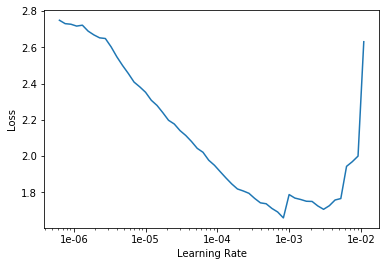

In [17]:
lr_find(learn)
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5,max_lr=3e-3, wd=0.3)

epoch,train_loss,valid_loss,pixel_acc,time
0,1.007145,0.515454,0.545912,01:16
1,0.758794,0.394219,0.639523,01:14
2,0.637545,0.470216,0.581049,01:13
3,0.535960,0.476629,0.599311,01:12
4,0.495311,0.390183,0.636542,01:12


In [ ]:
learn.save('resnet_50_5_frozen_epochs_balanced_focal_loss_mixup')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10,max_lr=3e-4, wd=0.3)

epoch,train_loss,valid_loss,pixel_acc,time
0,0.485417,0.415141,0.621866,01:13
1,0.473035,0.438090,0.616746,01:12
2,0.470010,0.442817,0.623092,01:13
3,0.463414,0.378002,0.625163,01:13


In [ ]:
learn.save('resnet_50_5_frozen+10_unfrozen_epochs_balanced_focal_loss_mixup')

In [ ]:
preds, targs = learn.get_preds(DatasetType.Valid)

In [ ]:
for c in range(10):
    print(f'{c}.{classes[c]:18} {pixel_acc_per_class(preds, targs, class_id=c+1)[1]:0.2f} '
          +f' on {pixel_acc_per_class(preds, targs, class_id=c+1)[0]:10} px')

In [ ]:
rows = 5

idxs = np.random.randint(0, len(preds), [rows])
fig = plt.figure(figsize=(15,4*rows))

nc = 5

for i,j in enumerate(idxs):
    pred = preds.argmax(dim=1)[j]
    targ = targs[j].squeeze()
    pred[targ==0]=0
    
    ax = plt.subplot(rows,nc,nc*i+1)
    plt.imshow(np.clip(data.valid_ds[j][0].data[0:3].permute([1,2,0])*3.5,0,1))
    ax.set_title('satellite')
    ax = plt.subplot(rows,nc,nc*i+2)
    plt.xticks([])
    plt.yticks([])
    
    ax.set_title('actual')
    plt.imshow(targ, vmin=0, vmax=9)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(rows,nc,nc*i+3)
    ax.set_title('predicted')
    plt.imshow(pred, vmin=0, vmax=9)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(rows,nc,nc*i+4)
    ax.set_title('where they match')
    plt.imshow((targ==pred)&(targ!=0), vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    
    ax = plt.subplot(rows,nc,nc*i+5)
    ax.set_title('where they are different')
    plt.imshow((targ!=pred)&(targ!=0), vmin=0, vmax=1)
    
    plt.xticks([])
    plt.yticks([])

fig.subplots_adjust(wspace=0.05, hspace=0.05)

### Inference on the test set

In [ ]:
field_ids_list = []
for f in data.test_ds.items:
    field_id = pkl.load(open(str(f).replace('feat','targ'),'rb'))
    field_ids_list.append(field_id)

In [ ]:
field_ids_arr = np.stack(field_ids_list).squeeze()

In [ ]:
preds_no_zero = (preds[:, 1:10, ...]).numpy()

In [ ]:
field_ids = np.unique(field_ids_arr)

In [ ]:
preds_list = list()

for fid in field_ids[1:]: #exclude 0
    
    prob_dic = {'Field_Id': fid} 

    preds = [np.median(preds_no_zero[:,c,...][field_ids_arr==fid]) for c in range(9)]
    probs = np.exp(preds)/sum(np.exp(preds))
    
    for i, p in enumerate(probs):
        prob_dic[f'crop_id_{i+1}'] = p
    
    preds_list.append(prob_dic)

In [ ]:
preds_df = pd.DataFrame(preds_list)

In [ ]:
preds_df.to_csv(output_path/'submission.csv',index=False)